In [1]:
# ----------------------------
# Cell 0: Imports + reproducibility + device
# ----------------------------
import os, math, random
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Reproducibility
SEED = 1337
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

device: cuda


In [2]:
# ----------------------------
# Cell 1: EfficientNetV2 backbone + multitask heads (lens logit + radius)
#         (drop-in replacement for ResNetBackbone/LensRadiusResNet)
# ----------------------------
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

# ============================================================
# EfficientNetV2 backbone (supports v2_s / v2_m / v2_l) + 1-channel input
# ============================================================
class EfficientNetV2Backbone(nn.Module):
    """
    Returns a pooled feature vector (B, feat_dim) from EfficientNetV2.
    Supports:
      - "efficientnet_v2_s"
      - "efficientnet_v2_m"
      - "efficientnet_v2_l"
    """
    def __init__(self, name="efficientnet_v2_s", in_channels=1, pretrained=False):
        super().__init__()
        name = name.lower().strip()
        assert name in {"efficientnet_v2_s", "efficientnet_v2_m", "efficientnet_v2_l"}, \
            f"Unknown EfficientNetV2 variant: {name}"

        # ---- build model (optionally pretrained) ----
        # NOTE: torchvision weights may need downloading; if unavailable, we fall back to random init.
        net = None
        if pretrained:
            try:
                if name == "efficientnet_v2_s":
                    net = models.efficientnet_v2_s(weights=models.EfficientNet_V2_S_Weights.DEFAULT)
                elif name == "efficientnet_v2_m":
                    net = models.efficientnet_v2_m(weights=models.EfficientNet_V2_M_Weights.DEFAULT)
                else:
                    net = models.efficientnet_v2_l(weights=models.EfficientNet_V2_L_Weights.DEFAULT)
            except Exception as e:
                print(f"[warn] pretrained weights unavailable ({e}); using random init instead.")
                pretrained = False

        if net is None:
            if name == "efficientnet_v2_s":
                net = models.efficientnet_v2_s(weights=None)
            elif name == "efficientnet_v2_m":
                net = models.efficientnet_v2_m(weights=None)
            else:
                net = models.efficientnet_v2_l(weights=None)

        # ---- replace first conv to accept 1-channel input ----
        # EfficientNetV2 stem conv lives at net.features[0][0]
        old_conv = net.features[0][0]
        new_conv = nn.Conv2d(
            in_channels=in_channels,
            out_channels=old_conv.out_channels,
            kernel_size=old_conv.kernel_size,
            stride=old_conv.stride,
            padding=old_conv.padding,
            dilation=old_conv.dilation,
            groups=old_conv.groups,
            bias=(old_conv.bias is not None),
            padding_mode=old_conv.padding_mode,
        )

        # If pretrained and in_channels==1, initialize by averaging RGB weights.
        # Otherwise, Kaiming init.
        if pretrained and in_channels == 1 and old_conv.weight.shape[1] == 3:
            with torch.no_grad():
                new_conv.weight.copy_(old_conv.weight.mean(dim=1, keepdim=True))
                if old_conv.bias is not None and new_conv.bias is not None:
                    new_conv.bias.copy_(old_conv.bias)
        else:
            nn.init.kaiming_normal_(new_conv.weight, mode="fan_out", nonlinearity="relu")
            if new_conv.bias is not None:
                nn.init.zeros_(new_conv.bias)

        net.features[0][0] = new_conv

        self.features = net.features
        self.pool = nn.AdaptiveAvgPool2d((1, 1))

        # Figure out feat_dim from classifier input
        # net.classifier is (Dropout, Linear(in_features, 1000))
        self.feat_dim = net.classifier[1].in_features

    def forward(self, x):
        x = self.features(x)       # (B,C,h,w)
        x = self.pool(x)           # (B,C,1,1)
        return x.flatten(1)        # (B,C)


class LensRadiusEffNetV2(nn.Module):
    """
    Multitask head:
      - lens_logit: (B,) raw logit for BCEWithLogitsLoss
      - r_pred:     (B,) radius prediction (match your target space)
    """
    def __init__(
        self,
        backbone="efficientnet_v2_s",
        in_channels=1,
        hidden=256,
        pretrained=False,
        add_noise=False,                
        gauss_std_range=(0.0, 0.1),     
        exp_log10_range=(3.0, 6.0),     
    ):
        super().__init__()
        self.backbone = EfficientNetV2Backbone(backbone, in_channels, pretrained)

        self.shared = nn.Sequential(
            nn.Linear(self.backbone.feat_dim, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(512, hidden),
            nn.ReLU(inplace=True),
        )
        self.cls_head = nn.Linear(hidden, 1)
        self.rad_head = nn.Linear(hidden, 1)

        self.add_noise = add_noise
        self.gauss_std_range = gauss_std_range
        self.exp_log10_range = exp_log10_range

    def forward(self, x):
        # x is already per-image normalized by your Dataset

        # --- Noise + Poisson-like noise (TRAIN ONLY) ---
        if self.training and self.add_noise:
            # Gaussian noise: std ~ Uniform(a,b)
            a, b = self.gauss_std_range
            std = torch.empty(1, device=x.device).uniform_(a, b).item()
            x = x + torch.randn_like(x) * std

            # Poisson-like noise
            lo, hi = self.exp_log10_range
            exp_log10 = torch.empty(1, device=x.device).uniform_(lo, hi).item()
            exp_time = 10.0 ** exp_log10

            sigma = torch.sqrt(torch.abs(x) / exp_time + 1e-8)
            x = x + torch.randn_like(x) * sigma

        # --- Backbone + heads ---
        f = self.backbone(x)
        h = self.shared(f)
        lens_logit = self.cls_head(h).squeeze(1)

        # IMPORTANT:
        # If your radius target is NORMALIZED (can be negative), do NOT use softplus.
        r_pred = F.softplus(self.rad_head(h)).squeeze(1)
        # r_pred = self.rad_head(h).squeeze(1)

        return lens_logit, r_pred

In [3]:
# ----------------------------
# Cell 2: Load data + shape fix (NO global normalization)
#         Per-image normalization happens inside the Dataset __getitem__.
# ----------------------------
import os
import numpy as np

path = "/global/cfs/projectdirs/deepsrch/jwst_sims/pristine_bright/"

x0      = np.load(os.path.join(path, "images.npy"))      # (N,H,W) or (N,1,H,W) or (N,H,W,1)
y_lens  = np.load(os.path.join(path, "lensed.npy"))      # (N,) 0/1
theta_e = np.load(os.path.join(path, "theta_Es.npy"))    # (N,) float

print("raw x0:", x0.shape, x0.dtype)
print("raw y_lens:", y_lens.shape, y_lens.dtype, "unique:", np.unique(y_lens)[:10])
print("raw theta_e:", theta_e.shape, theta_e.dtype)

# --- ensure x0 is (N,1,H,W) float32 ---
x0 = x0.astype(np.float32)

if x0.ndim == 3:
    # (N,H,W) -> (N,1,H,W)
    x0 = x0[:, None, :, :]
elif x0.ndim == 4:
    # if channels-last (N,H,W,1) -> channels-first
    if x0.shape[-1] == 1:
        x0 = np.transpose(x0, (0, 3, 1, 2))
    # else assume already (N,1,H,W) or (N,C,H,W) (we expect C=1)
else:
    raise ValueError(f"Unexpected x0 shape: {x0.shape}")

if x0.shape[1] != 1:
    raise ValueError(f"Expected 1 channel, got x0 shape {x0.shape}")

# --- labels / targets types ---
y_lens  = y_lens.astype(np.int64)      # 0/1
theta_e = theta_e.astype(np.float32)   # float

print("processed x0:", x0.shape, x0.dtype, "min/max:", float(x0.min()), float(x0.max()))

print(
    "theta_e:",
    theta_e.shape,
    theta_e.dtype,
    "min/max:",
    float(theta_e.min()),
    float(theta_e.max())
)

raw x0: (20000, 125, 125) float64
raw y_lens: (20000,) float64 unique: [0. 1.]
raw theta_e: (20000,) float64
processed x0: (20000, 1, 125, 125) float32 min/max: 0.014326992444694042 2639766.25
theta_e: (20000,) float32 min/max: 0.0 1.4998998641967773


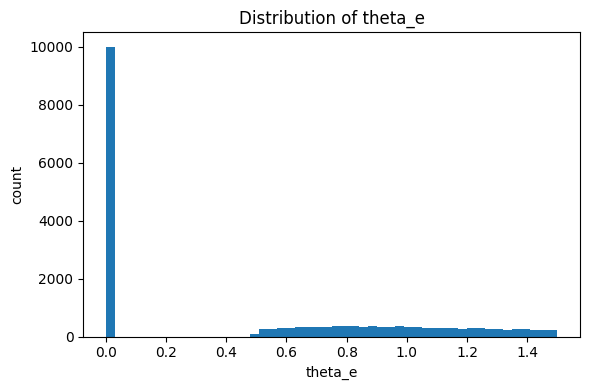

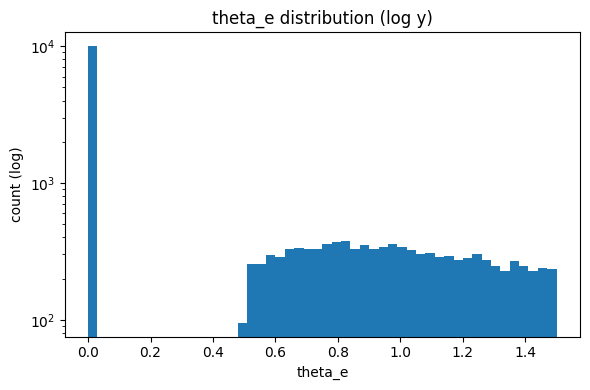

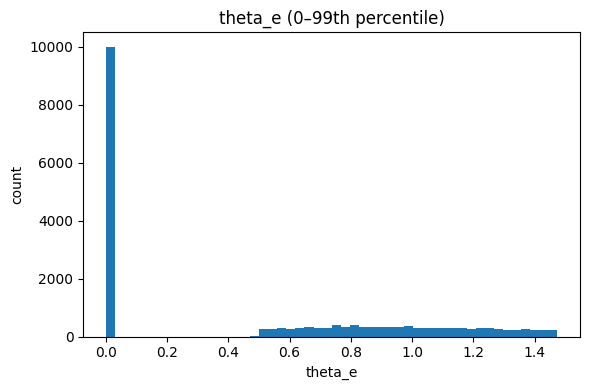

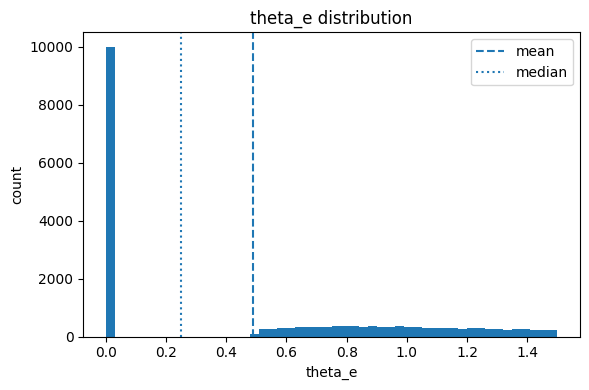

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.hist(theta_e, bins=50)
plt.xlabel("theta_e")
plt.ylabel("count")
plt.title("Distribution of theta_e")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
plt.hist(theta_e, bins=50)
plt.yscale("log")
plt.xlabel("theta_e")
plt.ylabel("count (log)")
plt.title("theta_e distribution (log y)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
plt.hist(theta_e, bins=50, range=(0, np.percentile(theta_e, 99)))
plt.xlabel("theta_e")
plt.ylabel("count")
plt.title("theta_e (0–99th percentile)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
plt.hist(theta_e, bins=50)
plt.axvline(theta_e.mean(), linestyle="--", label="mean")
plt.axvline(np.median(theta_e), linestyle=":", label="median")
plt.legend()
plt.xlabel("theta_e")
plt.ylabel("count")
plt.title("theta_e distribution")
plt.tight_layout()
plt.show()

In [5]:
# ----------------------------
# Cell 3: Dataset (per-image norm) + train/val split + radius normalization
# ----------------------------
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import numpy as np
import torch

class LensRadiusDataset(Dataset):
    def __init__(self, x, y, r, r_mean=None, r_std=None):
        # keep as torch tensors
        self.x = torch.from_numpy(x).float()   # (N,1,H,W)
        self.y = torch.from_numpy(y).long()    # (N,)
        self.r = torch.from_numpy(r).float()   # (N,)

        # optional target normalization for radius
        self.r_mean = None if r_mean is None else float(r_mean)
        self.r_std  = None if r_std  is None else float(r_std)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        x = self.x[idx]  # (1,H,W)

        # per-image normalization (match inference)
        m = x.mean()
        s = x.std().clamp(min=1e-6)
        x = (x - m) / s

        y = self.y[idx]
        r = self.r[idx]

        #normalize radius target if stats provided
        if self.r_mean is not None and self.r_std is not None:
            r = (r - self.r_mean) / self.r_std

        return x, y, r


# --- split ---
idx_all = np.arange(len(y_lens))
train_idx, val_idx = train_test_split(
    idx_all,
    test_size=0.20,
    random_state=SEED,
    stratify=y_lens
)

x_train, y_train, r_train = x0[train_idx], y_lens[train_idx], theta_e[train_idx]
x_val,   y_val,   r_val   = x0[val_idx],   y_lens[val_idx],   theta_e[val_idx]

print("train:", x_train.shape, y_train.shape, r_train.shape)
print("val:  ", x_val.shape,   y_val.shape,   r_val.shape)

# --- radius normalization stats from TRAIN ONLY ---
R_MEAN = float(r_train.mean())
R_STD  = float(r_train.std() + 1e-8)
print("R_MEAN:", R_MEAN, "R_STD:", R_STD)

train_ds = LensRadiusDataset(x_train, y_train, r_train, r_mean=R_MEAN, r_std=R_STD)
val_ds   = LensRadiusDataset(x_val,   y_val,   r_val,   r_mean=R_MEAN, r_std=R_STD)

# --- loaders ---
BATCH_SIZE = 128
NUM_WORKERS = 4  # set to 0 if your environment has dataloader issues

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=True, drop_last=False)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True, drop_last=False)

train: (16000, 1, 125, 125) (16000,) (16000,)
val:   (4000, 1, 125, 125) (4000,) (4000,)
R_MEAN: 0.48793089389801025 R_STD: 0.5252381563186646


In [6]:
# ----------------------------
# Cell 4: Build model (EffNetV2) + DataParallel + class-imbalance loss + AdaBelief
#         (mirrors your ResNet notebook behavior)
# ----------------------------
import torch
import torch.nn as nn
from collections import Counter

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Build model (EfficientNetV2 version) ---
# choose: "efficientnet_v2_s" | "efficientnet_v2_m" | "efficientnet_v2_l"
BACKBONE = "efficientnet_v2_l"
PRETRAINED = True  # set False if weights can't download in your environment

# model = LensRadiusEffNetV2(
#     backbone=BACKBONE,
#     in_channels=1,
#     hidden=256,
#     pretrained=PRETRAINED
# )

model = LensRadiusEffNetV2(
    backbone=BACKBONE,
    in_channels=1,
    hidden=256,
    pretrained=PRETRAINED,
    add_noise=True
)

# --- DataParallel (only if multiple GPUs available) ---
if torch.cuda.device_count() > 1:
    print("Using DataParallel with", torch.cuda.device_count(), "GPUs")
    model = torch.nn.DataParallel(model)

model = model.to(device)

# --- Class imbalance for lens classification loss ---
# We stratified using y_lens earlier; use the SAME labels for train_idx counts
counts = Counter(y_lens[train_idx].tolist())
n_neg = counts.get(0, 0)
n_pos = counts.get(1, 0)

pos_weight_cls = torch.tensor([n_neg / max(n_pos, 1)], dtype=torch.float32).to(device)
print("class counts:", counts, "pos_weight:", float(pos_weight_cls.item()))

# IMPORTANT: actually use pos_weight_cls here
bce = nn.BCEWithLogitsLoss(pos_weight=pos_weight_cls)

# --- Radius regression loss ---
reg = nn.SmoothL1Loss()
lambda_reg = 1.0  # same as your notebook

# --- AdaBelief optimizer (same hyperparams as your notebook) ---
from adabelief_pytorch import AdaBelief

optimizer = AdaBelief(
    model.parameters(),
    lr=3e-4,
    eps=1e-8,
    betas=(0.9, 0.999),
    weight_decay=1e-5,
    rectify=True,
    print_change_log=False
)

Using DataParallel with 4 GPUs
class counts: Counter({0: 8000, 1: 8000}) pos_weight: 1.0
Weight decoupling enabled in AdaBelief
Rectification enabled in AdaBelief


In [7]:
# ----------------------------
# Cell 5: Train + Val loop (BCE pos_weight + SmoothL1) + best checkpoint
# ----------------------------
import os
import numpy as np
import torch
from tqdm import tqdm

SAVE_DIR = "models/models_effnetv2_l_multihead"
os.makedirs(SAVE_DIR, exist_ok=True)

EPOCHS = 200
patience = 0
max_patience = 20
best_val_loss = float("inf")
best_path = os.path.join(SAVE_DIR, f"best_{BACKBONE}.pth")

def unwrap(m):
    return m.module if isinstance(m, torch.nn.DataParallel) else m

def run_one_epoch(model, loader, train: bool):
    if train:
        model.train()
    else:
        model.eval()

    total_loss = 0.0
    total_cls  = 0.0

    # For masked regression: accumulate reg loss weighted by #lens samples
    total_reg = 0.0
    n_reg     = 0  # number of samples contributing to reg loss (y==1)

    # metrics
    correct = 0
    n_total = 0

    # (optional) store logits/probs for later metrics
    logits_all = []
    y_all = []

    pbar = tqdm(loader, desc=("train" if train else "val"), leave=False)
    for x, y, r in pbar:
        x = x.to(device, non_blocking=True)            # (B,1,H,W) already per-image normalized
        y = y.to(device, non_blocking=True).float()    # BCE wants float targets
        r = r.to(device, non_blocking=True).float()    # normalized radius target

        if train:
            optimizer.zero_grad(set_to_none=True)

        with torch.set_grad_enabled(train):
            lens_logit, r_pred = model(x)  # lens_logit: (B,), r_pred: (B,)

            cls_loss = bce(lens_logit, y)

            # --- masked regression: only compute radius loss on TRUE lenses ---
            mask = (y > 0.5)  # y is float 0/1
            n_reg_batch = int(mask.sum().item())

            if n_reg_batch > 0:
                reg_loss = reg(r_pred[mask], r[mask])
            else:
                # scalar tensor on the right device/dtype so loss math works
                reg_loss = torch.zeros((), device=x.device, dtype=cls_loss.dtype)

            loss = cls_loss + lambda_reg * reg_loss

            if train:
                loss.backward()
                optimizer.step()

        # --- totals / metrics ---
        bs = int(x.size(0))
        total_loss += float(loss.item()) * bs
        total_cls  += float(cls_loss.item()) * bs

        # reg is averaged over lens samples only
        if n_reg_batch > 0:
            total_reg += float(reg_loss.item()) * n_reg_batch
            n_reg     += n_reg_batch

        # accuracy on lens prediction (threshold 0 on logits => p>=0.5)
        preds = (lens_logit.detach() > 0).long()
        correct += int((preds == y.long()).sum().item())
        n_total += bs

        logits_all.append(lens_logit.detach().cpu())
        y_all.append(y.detach().cpu())

        pbar.set_postfix({
            "loss": total_loss / max(n_total, 1),
            "cls":  total_cls  / max(n_total, 1),
            "reg":  total_reg  / max(n_reg, 1),   # <-- IMPORTANT: denom is lens count
            "acc":  correct    / max(n_total, 1),
            "nreg": n_reg
        })

    avg_loss = total_loss / max(n_total, 1)
    avg_cls  = total_cls  / max(n_total, 1)
    avg_reg  = total_reg  / max(n_reg, 1)  # average reg loss over lenses only
    acc      = correct    / max(n_total, 1)

    logits_all = torch.cat(logits_all, dim=0)
    y_all      = torch.cat(y_all, dim=0)

    return avg_loss, avg_cls, avg_reg, acc, logits_all, y_all


history = {
    "train_loss": [], "train_cls": [], "train_reg": [], "train_acc": [],
    "val_loss":   [], "val_cls":   [], "val_reg":   [], "val_acc":   [],
}

for epoch in range(1, EPOCHS + 1):
    tr_loss, tr_cls, tr_reg, tr_acc, _, _ = run_one_epoch(model, train_loader, train=True)

    with torch.no_grad():
        va_loss, va_cls, va_reg, va_acc, va_logits, va_y = run_one_epoch(model, val_loader, train=False)

    history["train_loss"].append(tr_loss)
    history["train_cls"].append(tr_cls)
    history["train_reg"].append(tr_reg)
    history["train_acc"].append(tr_acc)

    history["val_loss"].append(va_loss)
    history["val_cls"].append(va_cls)
    history["val_reg"].append(va_reg)
    history["val_acc"].append(va_acc)

    print(
        f"Epoch {epoch:02d}/{EPOCHS} | "
        f"train loss {tr_loss:.4f} (cls {tr_cls:.4f}, reg {tr_reg:.4f}) acc {tr_acc:.4f} | "
        f"val loss {va_loss:.4f} (cls {va_cls:.4f}, reg {va_reg:.4f}) acc {va_acc:.4f}"
    )

    # Save best (by total val loss, like typical multitask)
    if va_loss < best_val_loss:
        best_val_loss = va_loss
        torch.save(
            {
                "epoch": epoch,
                "backbone": BACKBONE,
                "model_state": unwrap(model).state_dict(),
                "optimizer_state": optimizer.state_dict(),
                "R_MEAN": R_MEAN,
                "R_STD": R_STD,
            },
            best_path
        )
        patience = 0
        print("  ✅ saved best:", best_path)
    else:
        patience += 1
        print("Patience:", patience) 
        if patience >= max_patience:
            break
    
print("Best val loss:", best_val_loss, "at:", best_path)



Epoch 01/200 | train loss 0.7448 (cls 0.6055, reg 0.1391) acc 0.7471 | val loss 0.7698 (cls 0.6289, reg 0.1408) acc 0.5262
  ✅ saved best: models/models_effnetv2_l_multihead/best_efficientnet_v2_l.pth


Epoch 02/200 | train loss 0.3111 (cls 0.2307, reg 0.0804) acc 0.9251 | val loss 0.4773 (cls 0.3538, reg 0.1232) acc 0.8820
  ✅ saved best: models/models_effnetv2_l_multihead/best_efficientnet_v2_l.pth


Epoch 03/200 | train loss 0.1860 (cls 0.1358, reg 0.0502) acc 0.9569 | val loss 0.3621 (cls 0.2694, reg 0.0923) acc 0.9038
  ✅ saved best: models/models_effnetv2_l_multihead/best_efficientnet_v2_l.pth


Epoch 04/200 | train loss 0.1444 (cls 0.1056, reg 0.0388) acc 0.9677 | val loss 0.3274 (cls 0.2410, reg 0.0861) acc 0.9113
  ✅ saved best: models/models_effnetv2_l_multihead/best_efficientnet_v2_l.pth


Epoch 05/200 | train loss 0.1197 (cls 0.0876, reg 0.0322) acc 0.9746 | val loss 0.2596 (cls 0.1941, reg 0.0653) acc 0.9295
  ✅ saved best: models/models_effnetv2_l_multihead/best_efficientnet_v2_l.pth


Epoch 06/200 | train loss 0.1008 (cls 0.0733, reg 0.0275) acc 0.9789 | val loss 0.3327 (cls 0.2669, reg 0.0656) acc 0.9105
Patience: 1


Epoch 07/200 | train loss 0.0868 (cls 0.0613, reg 0.0255) acc 0.9820 | val loss 0.2069 (cls 0.1396, reg 0.0671) acc 0.9535
  ✅ saved best: models/models_effnetv2_l_multihead/best_efficientnet_v2_l.pth


Epoch 08/200 | train loss 0.0831 (cls 0.0606, reg 0.0226) acc 0.9834 | val loss 0.2393 (cls 0.1821, reg 0.0570) acc 0.9387
Patience: 1


Epoch 09/200 | train loss 0.0751 (cls 0.0550, reg 0.0202) acc 0.9851 | val loss 0.2255 (cls 0.1839, reg 0.0415) acc 0.9270
Patience: 2


Epoch 10/200 | train loss 0.0731 (cls 0.0538, reg 0.0194) acc 0.9850 | val loss 0.2598 (cls 0.1928, reg 0.0668) acc 0.9347
Patience: 3


Epoch 11/200 | train loss 0.0690 (cls 0.0511, reg 0.0179) acc 0.9853 | val loss 0.2869 (cls 0.2474, reg 0.0392) acc 0.8645
Patience: 4


Epoch 12/200 | train loss 0.0636 (cls 0.0473, reg 0.0163) acc 0.9867 | val loss 0.2684 (cls 0.2437, reg 0.0246) acc 0.8525
Patience: 5


Epoch 13/200 | train loss 0.0602 (cls 0.0447, reg 0.0155) acc 0.9878 | val loss 0.1350 (cls 0.1086, reg 0.0262) acc 0.9688
  ✅ saved best: models/models_effnetv2_l_multihead/best_efficientnet_v2_l.pth


Epoch 14/200 | train loss 0.0610 (cls 0.0466, reg 0.0144) acc 0.9869 | val loss 0.1216 (cls 0.1004, reg 0.0211) acc 0.9805
  ✅ saved best: models/models_effnetv2_l_multihead/best_efficientnet_v2_l.pth


Epoch 15/200 | train loss 0.0558 (cls 0.0421, reg 0.0137) acc 0.9885 | val loss 0.0955 (cls 0.0771, reg 0.0182) acc 0.9845
  ✅ saved best: models/models_effnetv2_l_multihead/best_efficientnet_v2_l.pth


Epoch 16/200 | train loss 0.0541 (cls 0.0414, reg 0.0126) acc 0.9884 | val loss 0.0828 (cls 0.0657, reg 0.0169) acc 0.9862
  ✅ saved best: models/models_effnetv2_l_multihead/best_efficientnet_v2_l.pth


Epoch 17/200 | train loss 0.0521 (cls 0.0393, reg 0.0127) acc 0.9894 | val loss 0.0660 (cls 0.0504, reg 0.0154) acc 0.9885
  ✅ saved best: models/models_effnetv2_l_multihead/best_efficientnet_v2_l.pth


Epoch 18/200 | train loss 0.0533 (cls 0.0409, reg 0.0125) acc 0.9879 | val loss 0.1082 (cls 0.0896, reg 0.0184) acc 0.9655
Patience: 1


Epoch 19/200 | train loss 0.0493 (cls 0.0379, reg 0.0114) acc 0.9891 | val loss 0.0955 (cls 0.0753, reg 0.0200) acc 0.9820
Patience: 2


Epoch 20/200 | train loss 0.0473 (cls 0.0368, reg 0.0105) acc 0.9899 | val loss 0.0663 (cls 0.0484, reg 0.0178) acc 0.9882
Patience: 3


Epoch 21/200 | train loss 0.0464 (cls 0.0357, reg 0.0107) acc 0.9901 | val loss 0.0488 (cls 0.0336, reg 0.0150) acc 0.9908
  ✅ saved best: models/models_effnetv2_l_multihead/best_efficientnet_v2_l.pth


Epoch 22/200 | train loss 0.0460 (cls 0.0358, reg 0.0102) acc 0.9895 | val loss 0.1151 (cls 0.0950, reg 0.0200) acc 0.9513
Patience: 1


Epoch 23/200 | train loss 0.0452 (cls 0.0349, reg 0.0102) acc 0.9906 | val loss 0.0366 (cls 0.0258, reg 0.0107) acc 0.9932
  ✅ saved best: models/models_effnetv2_l_multihead/best_efficientnet_v2_l.pth


Epoch 24/200 | train loss 0.0422 (cls 0.0330, reg 0.0092) acc 0.9906 | val loss 0.0429 (cls 0.0325, reg 0.0103) acc 0.9915
Patience: 1


Epoch 25/200 | train loss 0.0425 (cls 0.0337, reg 0.0088) acc 0.9906 | val loss 0.0484 (cls 0.0352, reg 0.0131) acc 0.9900
Patience: 2


Epoch 26/200 | train loss 0.0419 (cls 0.0331, reg 0.0088) acc 0.9905 | val loss 0.0449 (cls 0.0313, reg 0.0134) acc 0.9925
Patience: 3


Epoch 27/200 | train loss 0.0434 (cls 0.0340, reg 0.0094) acc 0.9904 | val loss 0.0457 (cls 0.0325, reg 0.0131) acc 0.9920
Patience: 4


Epoch 28/200 | train loss 0.0412 (cls 0.0327, reg 0.0085) acc 0.9902 | val loss 0.0658 (cls 0.0493, reg 0.0164) acc 0.9878
Patience: 5


Epoch 29/200 | train loss 0.0391 (cls 0.0308, reg 0.0084) acc 0.9912 | val loss 0.0395 (cls 0.0293, reg 0.0101) acc 0.9918
Patience: 6


Epoch 30/200 | train loss 0.0363 (cls 0.0285, reg 0.0078) acc 0.9915 | val loss 0.0315 (cls 0.0236, reg 0.0078) acc 0.9945
  ✅ saved best: models/models_effnetv2_l_multihead/best_efficientnet_v2_l.pth


Epoch 31/200 | train loss 0.0395 (cls 0.0315, reg 0.0080) acc 0.9906 | val loss 0.0702 (cls 0.0504, reg 0.0196) acc 0.9850
Patience: 1


Epoch 32/200 | train loss 0.0347 (cls 0.0273, reg 0.0073) acc 0.9923 | val loss 0.0425 (cls 0.0312, reg 0.0111) acc 0.9910
Patience: 2


Epoch 33/200 | train loss 0.0357 (cls 0.0282, reg 0.0075) acc 0.9916 | val loss 0.0420 (cls 0.0294, reg 0.0124) acc 0.9925
Patience: 3


Epoch 34/200 | train loss 0.0356 (cls 0.0280, reg 0.0076) acc 0.9919 | val loss 0.0349 (cls 0.0265, reg 0.0083) acc 0.9940
Patience: 4


Epoch 35/200 | train loss 0.0341 (cls 0.0275, reg 0.0067) acc 0.9920 | val loss 0.0388 (cls 0.0274, reg 0.0113) acc 0.9938
Patience: 5


Epoch 36/200 | train loss 0.0323 (cls 0.0255, reg 0.0069) acc 0.9930 | val loss 0.0397 (cls 0.0313, reg 0.0083) acc 0.9932
Patience: 6


Epoch 37/200 | train loss 0.0313 (cls 0.0246, reg 0.0066) acc 0.9928 | val loss 0.0444 (cls 0.0362, reg 0.0081) acc 0.9928
Patience: 7


Epoch 38/200 | train loss 0.0349 (cls 0.0281, reg 0.0068) acc 0.9921 | val loss 0.0385 (cls 0.0302, reg 0.0083) acc 0.9938
Patience: 8


Epoch 39/200 | train loss 0.0315 (cls 0.0250, reg 0.0065) acc 0.9928 | val loss 0.0370 (cls 0.0274, reg 0.0095) acc 0.9942
Patience: 9


Epoch 40/200 | train loss 0.0334 (cls 0.0266, reg 0.0068) acc 0.9921 | val loss 0.0403 (cls 0.0308, reg 0.0094) acc 0.9912
Patience: 10


Epoch 41/200 | train loss 0.0403 (cls 0.0334, reg 0.0068) acc 0.9906 | val loss 0.0379 (cls 0.0281, reg 0.0098) acc 0.9922
Patience: 11


Epoch 42/200 | train loss 0.0329 (cls 0.0268, reg 0.0061) acc 0.9922 | val loss 0.0334 (cls 0.0255, reg 0.0078) acc 0.9938
Patience: 12


Epoch 43/200 | train loss 0.0298 (cls 0.0237, reg 0.0062) acc 0.9929 | val loss 0.0390 (cls 0.0308, reg 0.0082) acc 0.9910
Patience: 13


Epoch 44/200 | train loss 0.0317 (cls 0.0255, reg 0.0063) acc 0.9929 | val loss 0.0330 (cls 0.0248, reg 0.0080) acc 0.9942
Patience: 14


Epoch 45/200 | train loss 0.0329 (cls 0.0267, reg 0.0062) acc 0.9927 | val loss 0.0348 (cls 0.0274, reg 0.0073) acc 0.9922
Patience: 15


Epoch 46/200 | train loss 0.0316 (cls 0.0255, reg 0.0061) acc 0.9921 | val loss 0.0409 (cls 0.0323, reg 0.0086) acc 0.9908
Patience: 16


Epoch 47/200 | train loss 0.0341 (cls 0.0283, reg 0.0058) acc 0.9916 | val loss 0.0405 (cls 0.0324, reg 0.0080) acc 0.9920
Patience: 17


Epoch 48/200 | train loss 0.0269 (cls 0.0213, reg 0.0057) acc 0.9936 | val loss 0.0286 (cls 0.0222, reg 0.0064) acc 0.9960
  ✅ saved best: models/models_effnetv2_l_multihead/best_efficientnet_v2_l.pth


Epoch 49/200 | train loss 0.0315 (cls 0.0258, reg 0.0057) acc 0.9923 | val loss 0.0365 (cls 0.0291, reg 0.0073) acc 0.9940
Patience: 1


Epoch 50/200 | train loss 0.0306 (cls 0.0250, reg 0.0057) acc 0.9927 | val loss 0.0462 (cls 0.0375, reg 0.0086) acc 0.9922
Patience: 2


Epoch 51/200 | train loss 0.0290 (cls 0.0236, reg 0.0054) acc 0.9936 | val loss 0.0346 (cls 0.0280, reg 0.0066) acc 0.9928
Patience: 3


Epoch 52/200 | train loss 0.0295 (cls 0.0240, reg 0.0055) acc 0.9932 | val loss 0.0332 (cls 0.0265, reg 0.0067) acc 0.9942
Patience: 4


Epoch 53/200 | train loss 0.0277 (cls 0.0222, reg 0.0055) acc 0.9941 | val loss 0.0377 (cls 0.0307, reg 0.0069) acc 0.9935
Patience: 5


Epoch 54/200 | train loss 0.0289 (cls 0.0237, reg 0.0052) acc 0.9931 | val loss 0.0428 (cls 0.0350, reg 0.0078) acc 0.9922
Patience: 6


Epoch 55/200 | train loss 0.0287 (cls 0.0231, reg 0.0056) acc 0.9931 | val loss 0.0441 (cls 0.0356, reg 0.0083) acc 0.9915
Patience: 7


Epoch 56/200 | train loss 0.0277 (cls 0.0227, reg 0.0051) acc 0.9936 | val loss 0.0356 (cls 0.0284, reg 0.0070) acc 0.9932
Patience: 8


Epoch 57/200 | train loss 0.0286 (cls 0.0235, reg 0.0051) acc 0.9930 | val loss 0.0381 (cls 0.0310, reg 0.0070) acc 0.9925
Patience: 9


Epoch 58/200 | train loss 0.0268 (cls 0.0218, reg 0.0050) acc 0.9933 | val loss 0.0399 (cls 0.0318, reg 0.0080) acc 0.9928
Patience: 10


Epoch 59/200 | train loss 0.0245 (cls 0.0198, reg 0.0047) acc 0.9945 | val loss 0.0364 (cls 0.0283, reg 0.0080) acc 0.9932
Patience: 11


Epoch 60/200 | train loss 0.0275 (cls 0.0226, reg 0.0049) acc 0.9931 | val loss 0.0433 (cls 0.0345, reg 0.0087) acc 0.9910
Patience: 12


Epoch 61/200 | train loss 0.0261 (cls 0.0212, reg 0.0049) acc 0.9938 | val loss 0.0375 (cls 0.0307, reg 0.0067) acc 0.9930
Patience: 13


Epoch 62/200 | train loss 0.0250 (cls 0.0202, reg 0.0049) acc 0.9943 | val loss 0.0319 (cls 0.0251, reg 0.0067) acc 0.9952
Patience: 14


Epoch 63/200 | train loss 0.0271 (cls 0.0222, reg 0.0049) acc 0.9936 | val loss 0.0421 (cls 0.0346, reg 0.0073) acc 0.9928
Patience: 15


Epoch 64/200 | train loss 0.0291 (cls 0.0243, reg 0.0049) acc 0.9931 | val loss 0.0324 (cls 0.0255, reg 0.0068) acc 0.9945
Patience: 16


Epoch 65/200 | train loss 0.0268 (cls 0.0220, reg 0.0048) acc 0.9932 | val loss 0.0344 (cls 0.0271, reg 0.0071) acc 0.9930
Patience: 17


Epoch 66/200 | train loss 0.0250 (cls 0.0205, reg 0.0045) acc 0.9937 | val loss 0.0324 (cls 0.0260, reg 0.0063) acc 0.9938
Patience: 18


Epoch 67/200 | train loss 0.0287 (cls 0.0241, reg 0.0046) acc 0.9934 | val loss 0.0366 (cls 0.0295, reg 0.0070) acc 0.9922
Patience: 19


Epoch 68/200 | train loss 0.0243 (cls 0.0196, reg 0.0047) acc 0.9944 | val loss 0.0375 (cls 0.0302, reg 0.0072) acc 0.9930
Patience: 20
Best val loss: 0.028611271008849144 at: models/models_effnetv2_l_multihead/best_efficientnet_v2_l.pth


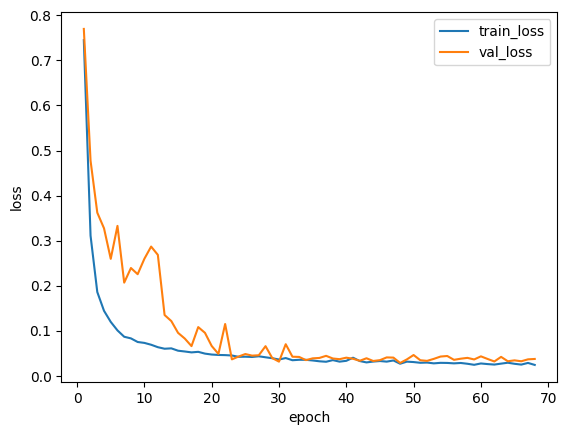

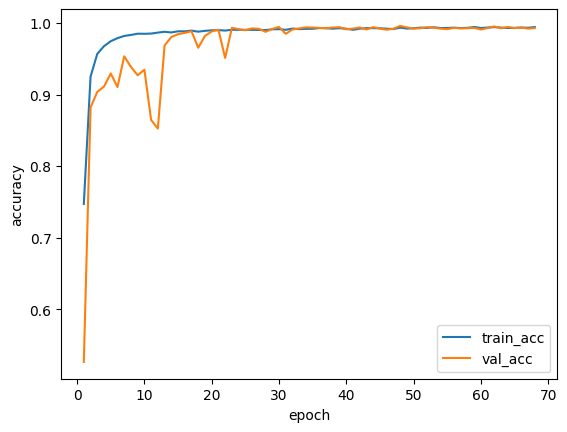

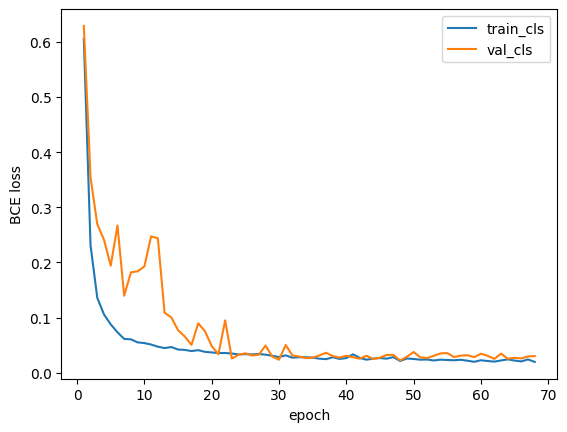

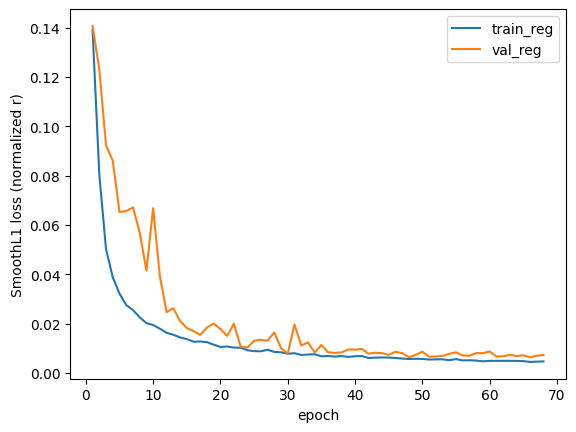

val probs range: 4.804381285167247e-12 1.0
val y counts: {0: 2000, 1: 2000}
val AUROC: 0.998821125
theta_E true (first 10): [0.6064436 1.4503012 0.        1.4837393 0.        1.4239675 1.0345172
 0.8870637 0.        0.       ]
theta_E pred (first 10): [0.5943853 1.420251  1.1087363 1.4158356 0.9283496 1.3878493 0.9825449
 0.9018282 1.1893473 0.859548 ]


In [8]:
# ----------------------------
# Cell 6: Curves + (optional) validation metrics + radius un-normalization demo
# ----------------------------
import numpy as np
import matplotlib.pyplot as plt
import torch

# --- plot curves ---
epochs = np.arange(1, len(history["train_loss"]) + 1)

plt.figure()
plt.plot(epochs, history["train_loss"], label="train_loss")
plt.plot(epochs, history["val_loss"],   label="val_loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, history["train_acc"], label="train_acc")
plt.plot(epochs, history["val_acc"],   label="val_acc")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, history["train_cls"], label="train_cls")
plt.plot(epochs, history["val_cls"],   label="val_cls")
plt.xlabel("epoch")
plt.ylabel("BCE loss")
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, history["train_reg"], label="train_reg")
plt.plot(epochs, history["val_reg"],   label="val_reg")
plt.xlabel("epoch")
plt.ylabel("SmoothL1 loss (normalized r)")
plt.legend()
plt.show()


# --- quick val: compute probabilities + (optional) AUROC if sklearn is available ---
val_probs = torch.sigmoid(va_logits).cpu().numpy()
val_y_np  = va_y.cpu().numpy().astype(np.int32)

print("val probs range:", float(val_probs.min()), float(val_probs.max()))
print("val y counts:", {0: int((val_y_np==0).sum()), 1: int((val_y_np==1).sum())})

try:
    from sklearn.metrics import roc_auc_score
    auc = roc_auc_score(val_y_np, val_probs)
    print("val AUROC:", auc)
except Exception as e:
    print("[info] AUROC not computed:", e)


# --- radius prediction un-normalization demo on a small val batch ---
model.eval()
with torch.no_grad():
    x, y, r_norm = next(iter(val_loader))
    x = x.to(device)
    lens_logit, r_pred_norm = model(x)

    # un-normalize back to theta_E units
    r_pred = r_pred_norm.cpu() * R_STD + R_MEAN
    r_true = r_norm.cpu() * R_STD + R_MEAN

print("theta_E true (first 10):", r_true[:10].numpy())
print("theta_E pred (first 10):", r_pred[:10].numpy())

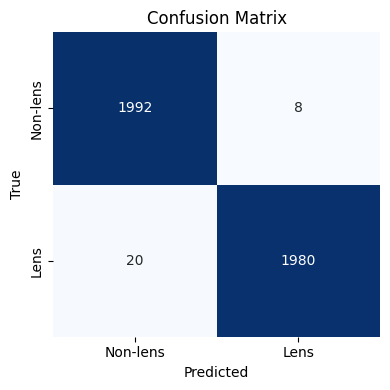

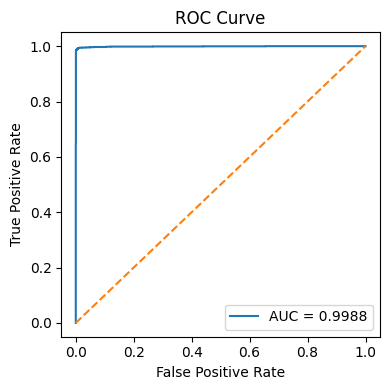

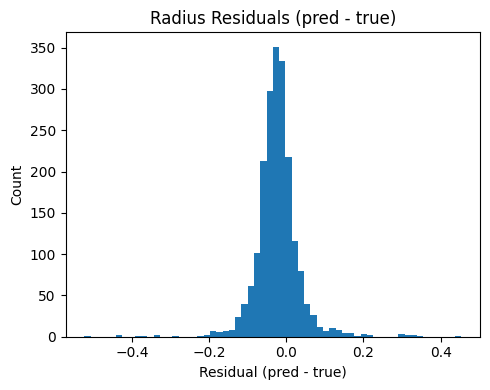

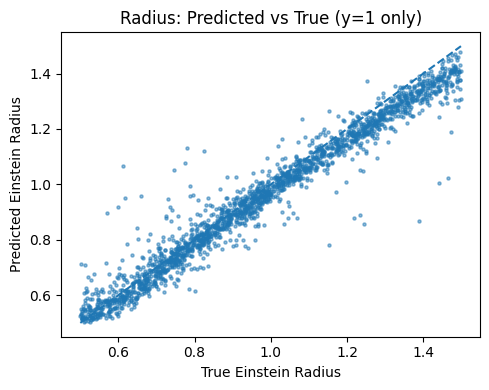

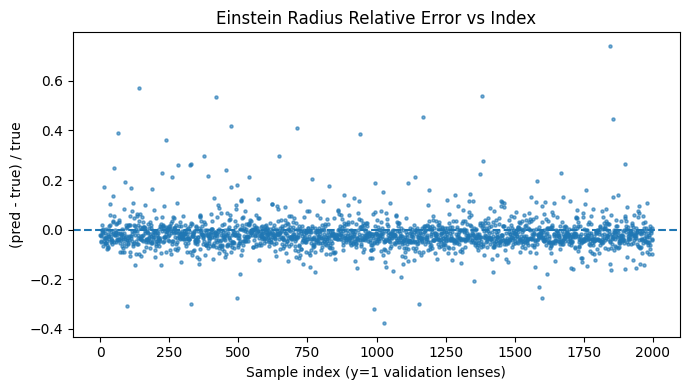

Validation AUC: 0.998821125
Radius MAE (y=1): 0.043499235
Radius RMSE (y=1): 0.06313925
Median relative error: -0.02555626


In [9]:
# ----------------------------
# Cell 7: Confusion Matrix + ROC + Radius Diagnostics (y=1 only)
# ----------------------------
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns

model.eval()

all_logits = []
all_probs  = []
all_y      = []
all_r_pred = []
all_r_true = []

with torch.no_grad():
    for x, y, r_norm in val_loader:
        x = x.to(device)
        y = y.to(device)

        logits, r_pred_norm = model(x)

        probs = torch.sigmoid(logits)

        # un-normalize radius
        r_pred = r_pred_norm.cpu() * R_STD + R_MEAN
        r_true = r_norm.cpu() * R_STD + R_MEAN

        all_logits.append(logits.cpu())
        all_probs.append(probs.cpu())
        all_y.append(y.cpu())
        all_r_pred.append(r_pred)
        all_r_true.append(r_true)

# --- stack ---
logits = torch.cat(all_logits).numpy()
probs  = torch.cat(all_probs).numpy()
y_true = torch.cat(all_y).numpy().astype(int)
r_pred = torch.cat(all_r_pred).numpy()
r_true = torch.cat(all_r_true).numpy()

# ============================
# Confusion Matrix
# ============================
y_pred = (probs >= 0.5).astype(int)
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Non-lens", "Lens"],
            yticklabels=["Non-lens", "Lens"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# ============================
# ROC Curve
# ============================
fpr, tpr, _ = roc_curve(y_true, probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(4,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.tight_layout()
plt.show()

# ============================
# Radius diagnostics (LENSES ONLY)
# ============================
mask = y_true == 1
r_pred_l = r_pred[mask]
r_true_l = r_true[mask]

# --- Residual histogram ---
residuals = r_pred_l - r_true_l

plt.figure(figsize=(5,4))
plt.hist(residuals, bins=60)
plt.xlabel("Residual (pred - true)")
plt.ylabel("Count")
plt.title("Radius Residuals (pred - true)")
plt.tight_layout()
plt.show()

# --- Predicted vs True ---
plt.figure(figsize=(5,4))
plt.scatter(r_true_l, r_pred_l, s=5, alpha=0.5)
lims = [r_true_l.min(), r_true_l.max()]
plt.plot(lims, lims, "--")
plt.xlabel("True Einstein Radius")
plt.ylabel("Predicted Einstein Radius")
plt.title("Radius: Predicted vs True (y=1 only)")
plt.tight_layout()
plt.show()

# --- Relative error vs index ---
rel_err = (r_pred_l - r_true_l) / r_true_l

plt.figure(figsize=(7,4))
plt.scatter(np.arange(len(rel_err)), rel_err, s=5, alpha=0.6)
plt.axhline(0, linestyle="--")
plt.xlabel("Sample index (y=1 validation lenses)")
plt.ylabel("(pred - true) / true")
plt.title("Einstein Radius Relative Error vs Index")
plt.tight_layout()
plt.show()

# ============================
# Summary stats
# ============================
print("Validation AUC:", roc_auc)
print("Radius MAE (y=1):", np.mean(np.abs(r_pred_l - r_true_l)))
print("Radius RMSE (y=1):", np.sqrt(np.mean((r_pred_l - r_true_l)**2)))
print("Median relative error:", np.median(rel_err))

In [10]:
# ============================
# Relative error statistics (y=1 only)
# ============================
rel_err = (r_pred_l - r_true_l) / r_true_l

print("Relative error stats:")
print(f"  mean: {rel_err.mean(): .4f}")
print(f"  std : {rel_err.std(): .4f}")
print(f"  min : {rel_err.min(): .4f}")
print(f"  max : {rel_err.max(): .4f}")

Relative error stats:
  mean: -0.0177
  std :  0.0674
  min : -0.3765
  max :  0.7402
